<a href="https://colab.research.google.com/github/merrymasti015/CAP2022GRP09/blob/main/PCAMZC321_Group09_FireEventDetection_Classical_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FireDetection SKLEARN-ML

### Histogram of Oriented Gradients(HOG)
# https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/

In [52]:
import os
import cv2
import itertools
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [53]:
#Import Random Forest Model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [54]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

ModelSaveFolder = "/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave"


Drive = "/content/gdrive/MyDrive/"
## Define root folder
RootFolder = Drive+"Fire_ImageDataSet/OutputFiles"

### Where to save models

ModelSaveFolder = Drive+"Fire_ImageDataSet/ModelSave"

print(ModelSaveFolder)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Fire_ImageDataSet/ModelSave


In [55]:
trainFrames  = pd.read_csv(RootFolder+"/Train_FramePathLocation.csv")

trainFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,N_image_89.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
1,N_image_886.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
2,N_image_896.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
3,N_image_96.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
4,N_image_95.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral


In [56]:
trainFrames.shape

(1775, 4)

In [57]:
#Count Unique Values of occupation
trainFrames['class'].value_counts()

Neutral    900
Fire       875
Name: class, dtype: int64

In [58]:
trainFrames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1775 entries, 0 to 1774
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   FrameFilename     1775 non-null   object
 1   FullPathName      1775 non-null   object
 2   GreyFullPathName  1775 non-null   object
 3   class             1775 non-null   object
dtypes: object(4)
memory usage: 55.6+ KB


In [59]:
#% of missing values in each column
def find_missing_values_func(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [60]:
#Call the find_missing_values_func(df)
columnsWiseMissingValue = find_missing_values_func(trainFrames) 
print(columnsWiseMissingValue)

Selected dataframe has 4 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


## Example

In [61]:
No_Of_images = trainFrames.shape[0]
print(No_Of_images)

# Images are of various sizes, therefore, all the images needs to be downscaled to size 64*64
ROWS = 64
COLS = 64
CHANNELS = 3

1775


In [62]:
n_x = ROWS * COLS * CHANNELS
print(n_x)
X = np.ndarray((n_x, No_Of_images), dtype=np.uint8)
y = np.zeros((1, No_Of_images))
print ("X shape is {}".format(X.shape))
print ("y shape is {}".format(y.shape))


12288
X shape is (12288, 1775)
y shape is (1, 1775)


In [63]:
print(X)

[[  0   0   0 ... 117 116 112]
 [117 116  32 ...  56  48 222]
 [208  58 228 ...  98  58 150]
 ...
 [  7 239 183 ... 191   0   9]
 [138 100 160 ... 199 191 188]
 [191  41  25 ... 145 196 191]]


In [64]:
print(y)

[[0. 0. 0. ... 0. 0. 0.]]


In [65]:
# Extract each frame  from trainFrames and store in a list - trainSetFramelist
trainSetFramelist = trainFrames["FullPathName"].tolist()
#print(trainSetFramelist)
print(len(trainSetFramelist))

1775


In [66]:
trainSetFramelist

['/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_89.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_886.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_896.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_96.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_95.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_90.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_890.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_91.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_99.jpg',
 '/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_891.jp

In [67]:
for i, image_file in enumerate(trainSetFramelist):
       print(i)
       print(image_file)


0
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_89.jpg
1
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_886.jpg
2
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_896.jpg
3
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_96.jpg
4
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_95.jpg
5
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_90.jpg
6
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_890.jpg
7
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_91.jpg
8
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_99.jpg
9
/content/gdrive/MyDrive/Fire_ImageDataSet//OutputFiles/BaseDataSet/Train/Neutral/N_image_891.jpg
10
/content/gdri

In [68]:
#trainFrames['class'][i]
trainFrames['class'][1730]


'Fire'

### end example

In [69]:
No_Of_images = trainFrames.shape[0]
print(No_Of_images)

# Images are of various sizes, therefore, all the images needs to be downscaled to size 64*64
ROWS = 64
COLS = 64
CHANNELS = 3

1775


In [70]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) 
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


In [71]:
def Feature_Engg(file_path_list, train_test):
    
    No_Of_images = len(file_path_list)
    n_x = ROWS * COLS * CHANNELS
    X = np.ndarray((n_x, No_Of_images), dtype=np.uint8)
    y = np.zeros((1, No_Of_images))

    
    for i, image_file in enumerate(file_path_list):
        image = read_image(image_file)
        X[:, i] = np.squeeze(image.reshape((n_x, 1)))                 
        if train_test['class'][i] == 'Neutral':
            y[0, i] = 1
        elif train_test['class'][i] == 'Fire':
            y[0, i] = 0
    return X, y


In [72]:
X_train, y_train = Feature_Engg(trainSetFramelist,trainFrames)
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))   

X_train shape: (12288, 1775)
y_train shape: (1, 1775)


In [73]:
print(X_train)

[[182  16  86 ...  94   0  24]
 [184  19 125 ...  95  37  13]
 [172  23 136 ... 109 116   8]
 ...
 [ 84  26  40 ... 137  21 217]
 [ 84  31  30 ... 140  78 197]
 [ 84  30  23 ... 144 181 179]]


In [74]:
print(y_train )

[[1. 1. 1. ... 0. 0. 0.]]


### For Test frames 

In [75]:
# read testFrames csv
testFrames  = pd.read_csv(RootFolder+"/Test_FramePathLocation.csv")
testFrames.shape

(187, 4)

In [76]:
testFrames.head()

,FrameFilename,FullPathName,GreyFullPathName,class
0,TN_image_4.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
1,TN_image_40.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
2,TN_image_39.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
3,TN_image_99.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral
4,TN_image_62.jpg,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,/content/gdrive/MyDrive/Fire_ImageDataSet//Out...,Neutral


In [77]:
#Call the find_missing_values_func(df)
columnsWiseMissingValue = find_missing_values_func(testFrames) 
print(columnsWiseMissingValue)

Selected dataframe has 4 columns.
There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


In [78]:
#Count Unique Values of occupation
testFrames['class'].value_counts()

Fire       97
Neutral    90
Name: class, dtype: int64

In [79]:
# Extract each  from testFrames 
testSetFramelist = testFrames["FullPathName"].tolist()
print(len(testSetFramelist))

187


In [80]:
X_test, y_test = Feature_Engg(testSetFramelist,testFrames)
print("X_test shape: {}".format(X_test.shape))
print("test_idx shape: {}".format(y_test.shape))  

X_test shape: (12288, 187)
test_idx shape: (1, 187)


In [81]:
# Tranpose the matrics 
X_train_T, y_train_T = X_train.T, y_train.T.ravel()  
# What is ravel
#This function returns a flattened one-dimensional array. 
#The returned array will have the same type as that of the input array. The function takes one parameter.


In [82]:
X_train_T

array([[182, 184, 172, ...,  84,  84,  84],
       [ 16,  19,  23, ...,  26,  31,  30],
       [ 86, 125, 136, ...,  40,  30,  23],
       ...,
       [ 94,  95, 109, ..., 137, 140, 144],
       [  0,  37, 116, ...,  21,  78, 181],
       [ 24,  13,   8, ..., 217, 197, 179]], dtype=uint8)

In [83]:
y_train_T

array([1., 1., 1., ..., 0., 0., 0.])

In [84]:
# Tranpose the test matrics 

X_test_T, y_test_T = X_test.T, y_test.T

In [85]:
y_test

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [86]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [87]:
def plot_roc_curve(model, yTest, yPred):
    fpr, tpr, thresholds = roc_curve(yTest, yPred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    #print('AUC area:', roc_auc)
    Model_accuracy = roc_auc_score(yTest,yPred)
    print('AUC roc_auc_score:', roc_auc_score(yTest,yPred))
    plt.plot([0,1],[0,1],'k--')
    #plt.plot(fpr,tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title(model)
    plt.show()
    return Model_accuracy,roc_auc

def getModelReport(modelName, yTest, yPredict) :
    accuracy = accuracy_score(yTest, yPredict)
    precision = precision_score(yTest, yPredict)
    recall = recall_score(yTest, yPredict)
    f1 = f1_score(yTest, yPredict)
    conf_matrix = confusion_matrix(yTest, yPredict)
    tn, fp, fn, tp = confusion_matrix(yTest, yPredict).ravel()
    precision_fire=tp/(tp+fp)                                                              # Precision = TruePositives / (TruePositives + FalsePositives)
    recall_fire= tp/(tp+fn)                                                                # Recall = TruePositives / (TruePositives + FalseNegatives)
    f1_fire= 2*precision_fire*recall_fire/(precision_fire*recall_fire)                     # (2 * Precision * Recall) / (Precision + Recall)
    precision_Neutral=tn/(tn+fn)                                                           # Precision = TruePositives / (TruePositives + FalsePositives)
    recall_Neutral= tn/(tn+fp)                                                             # Recall = TruePositives / (TruePositives + FalseNegatives)
    f1_Neutral= 2*precision_Neutral*recall_Neutral/(precision_Neutral*recall_Neutral)      # (2 * Precision * Recall) / (Precision + Recall)

    clf_report = classification_report(yTest, yPredict)

    print('\n\n*************************************************************************************')
    print('FOR {0}:'.format(modelName))
    print('ACCURACY:', accuracy)
    print('F1 SCORE:', f1)
    print('CONFUSION MATRIX: ')
    print(conf_matrix)
    print('CLASSIFICATION REPORT: ')
    print(clf_report)
    print('****************************************************************************************')
    return f1,precision_fire,recall_fire,f1_fire,precision_Neutral,recall_Neutral,f1_Neutral


In [88]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12288, 1775)
(1, 1775)
(12288, 187)
(1, 187)


from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = KNeighborsClassifier(n_neighbors=5)


*************************************************************************************
FOR KNN:
ACCURACY: 0.6524064171122995
F1 SCORE: 0.6285714285714287
CONFUSION MATRIX: 
[[67 30]
 [35 55]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67        97
         1.0       0.65      0.61      0.63        90

    accuracy                           0.65       187
   macro avg       0.65      0.65      0.65       187
weigh

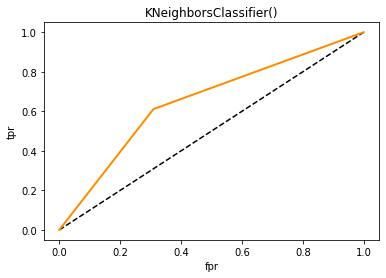

  Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0   KNN     0.611111        0.647059        0.690722           0.656863   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.650916  0.650916  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = XGBClassifier(max_depth=2)


*************************************************************************************
FOR XGBoost:
ACCURACY: 0.7540106951871658
F1 SCORE: 0.7386363636363636
CONFUSION MATRIX: 
[[76 21]
 [25 65]]
CLASSIFICATION REPORT: 
              precisio

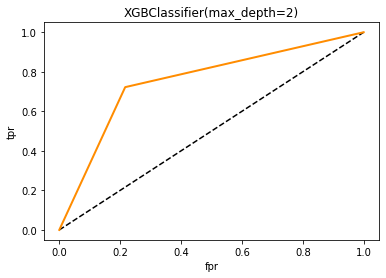

     Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0  XGBoost     0.722222        0.755814        0.783505           0.752475   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.752864  0.752864  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = RandomForestClassifier(n_estimators=100)


*************************************************************************************
FOR RandomForest:
ACCURACY: 0.7219251336898396
F1 SCORE: 0.7011494252873564
CONFUSION MATRIX: 
[[74 23]
 [29 61]]
CLASSIFICATION REPORT

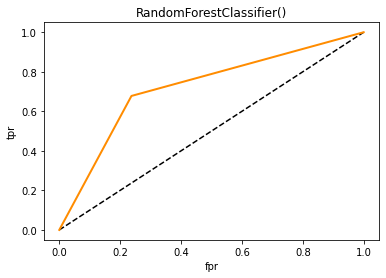

          Model  recall_fire  precision_fire  recall_neutral  \
0  RandomForest     0.677778         0.72619        0.762887   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.718447      2.0         2.0        0.720332  0.720332  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM:
ACCURACY: 0.7005347593582888
F1 SCORE: 0.6626506024096386
CONFUSION MATRIX: 
[[76 21]
 [35 55]]
CLASSIFICATION REPORT: 
 

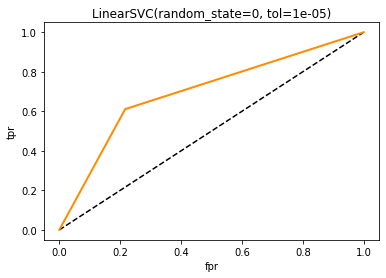

  Model  recall_fire  precision_fire  recall_neutral  precision_neutral  \
0   SVM     0.611111        0.723684        0.783505           0.684685   

   f1_fire  f1_neutral  model_accuracy   roc_auc  
0      2.0         2.0        0.697308  0.697308  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = DecisionTreeClassifier()


*************************************************************************************
FOR DecisionTree:
ACCURACY: 0.6898395721925134
F1 SCORE: 0.6588235294117647
CONFUSION MATRIX: 
[[73 24]
 [34 56]]
CLASSIFICATION REPORT: 
              preci

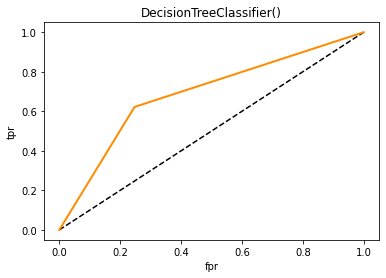

          Model  recall_fire  precision_fire  recall_neutral  \
0  DecisionTree     0.622222             0.7        0.752577   

   precision_neutral  f1_fire  f1_neutral  model_accuracy  roc_auc  
0           0.682243      2.0         2.0          0.6874   0.6874  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GaussianNB()


*************************************************************************************
FOR Naive_Bayes:
ACCURACY: 0.6844919786096256
F1 SCORE: 0.6703910614525139
CONFUSION MATRIX: 
[[68 29]
 [30 60]]
CLASSIFICATION REPORT: 
              prec

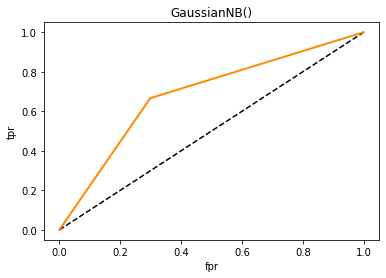

         Model  recall_fire  precision_fire  recall_neutral  \
0  Naive_Bayes     0.666667        0.674157        0.701031   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.693878      2.0         2.0        0.683849  0.683849  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LogisticRegressionCV()


*************************************************************************************
FOR LogisticRegressionCV:
ACCURACY: 0.7005347593582888
F1 SCORE: 0.6666666666666666
CONFUSION MATRIX: 
[[75 22]
 [34 56]]
CLASSIFICATION REPORT: 

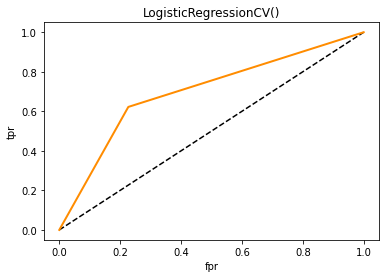

                  Model  recall_fire  precision_fire  recall_neutral  \
0  LogisticRegressionCV     0.622222        0.717949        0.773196   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.688073      2.0         2.0        0.697709  0.697709  
(1, 9)
(7, 9)


In [89]:
import pickle

def predict_classic_models(args,X_train, y_train, X_test,y_test):
    model_run_script = """from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

"""
    model_eval_data = pd.DataFrame()
    model_run_script = model_run_script+'model = '+ args[1] + '('+ args[2] +')'
    Vars = {}
    print(model_run_script)
    exec(model_run_script, Vars)
    model = Vars['model']
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    f1,precision_fire,recall_fire,f1_fire,precision_Neutral,recall_Neutral,f1_Neutral = getModelReport(args[0], y_test, y_predict)
    # roc curve
    model_eval_data['Model'] = [args[0]]
    model_eval_data['recall_fire'] = [recall_fire]
    model_eval_data['precision_fire'] = [precision_fire]
    model_eval_data['recall_neutral'] = [recall_Neutral]
    model_eval_data['precision_neutral'] = [precision_Neutral]
    model_eval_data['f1_fire'] = [f1_fire]
    model_eval_data['f1_neutral'] = [f1_Neutral]
    file_name = ModelSaveFolder+'/'+args[1]+'.h5'
    pickle.dump(model, open(file_name,'wb'))

    Model_acc,roc_auc=plot_roc_curve(model,y_test,y_predict)

    model_eval_data['model_accuracy'] = [Model_acc]
    model_eval_data['roc_auc'] = [roc_auc]
    print(model_eval_data)
    print(model_eval_data.shape)
    return model_eval_data

#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV','']]

eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,X_train_T, y_train_T, X_test_T,y_test_T)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval.csv',header=True, index=False)

In [90]:
SKLearn_Model_Data = {}
Model_accuracy = {}

### Further pre-processing - Scaling Data MinMaxScaler

In [91]:
from sklearn import preprocessing

In [92]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train_T)
X_test_minmax  = min_max_scaler.fit_transform(X_test_T)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = KNeighborsClassifier(n_neighbors=5)


*************************************************************************************
FOR KNN_minimax:
ACCURACY: 0.6470588235294118
F1 SCORE: 0.6250000000000001
CONFUSION MATRIX: 
[[66 31]
 [35 55]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         0.0       0.65      0.68      0.67        97
         1.0       0.64      0.61      0.63        90

    accuracy                           0.65       187
   macro avg       0.65      0.65      0.65       1

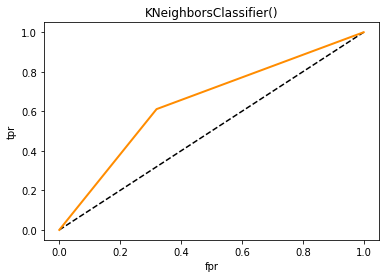

         Model  recall_fire  precision_fire  recall_neutral  \
0  KNN_minimax     0.611111        0.639535        0.680412   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.653465      2.0         2.0        0.645762  0.645762  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = XGBClassifier(max_depth=2)


*************************************************************************************
FOR XGBoost_minimax:
ACCURACY: 0.7593582887700535
F1 SCORE: 0.7457627118644068
CONFUSION MATRIX: 
[[76 21]
 [24 66]]
CLASSIFICATION REPORT: 


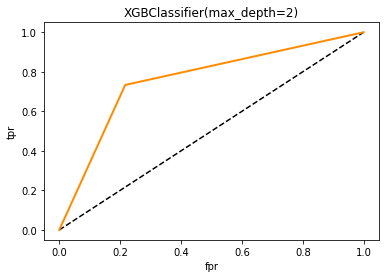

             Model  recall_fire  precision_fire  recall_neutral  \
0  XGBoost_minimax     0.733333        0.758621        0.783505   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0               0.76      2.0         2.0        0.758419  0.758419  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = RandomForestClassifier(n_estimators=100)


*************************************************************************************
FOR RandomForest_minimax:
ACCURACY: 0.7379679144385026
F1 SCORE: 0.72
CONFUSION MATRIX: 
[[75 22]
 [27 63]]
CLASSIFICAT

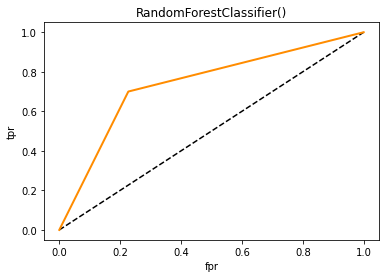

                  Model  recall_fire  precision_fire  recall_neutral  \
0  RandomForest_minimax          0.7        0.741176        0.773196   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.735294      2.0         2.0        0.736598  0.736598  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM_minimax:
ACCURACY: 0.7005347593582888
F1 SCORE: 0.6666666666666666
CONFUSION MATRIX: 
[[75 22]
 [34 56]]
C

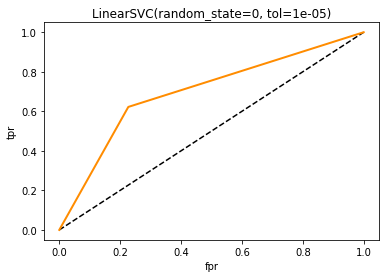

         Model  recall_fire  precision_fire  recall_neutral  \
0  SVM_minimax     0.622222        0.717949        0.773196   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.688073      2.0         2.0        0.697709  0.697709  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = DecisionTreeClassifier()


*************************************************************************************
FOR DecisionTree_minimax:
ACCURACY: 0.679144385026738
F1 SCORE: 0.6590909090909091
CONFUSION MATRIX: 
[[69 28]
 [32 58]]
CLASSIFICATION REPORT:

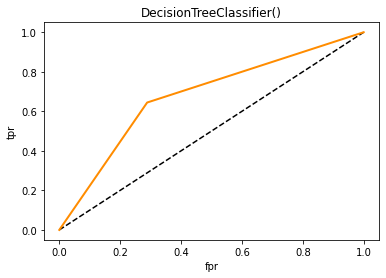

                  Model  recall_fire  precision_fire  recall_neutral  \
0  DecisionTree_minimax     0.644444        0.674419         0.71134   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.683168      2.0         2.0        0.677892  0.677892  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GaussianNB()


*************************************************************************************
FOR Naive_Bayes_minimax:
ACCURACY: 0.6898395721925134
F1 SCORE: 0.6813186813186812
CONFUSION MATRIX: 
[[67 30]
 [28 62]]
CLASSIFICATION R

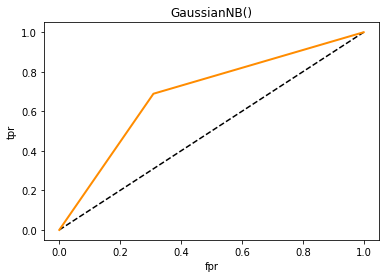

                 Model  recall_fire  precision_fire  recall_neutral  \
0  Naive_Bayes_minimax     0.688889        0.673913        0.690722   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.705263      2.0         2.0        0.689805  0.689805  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LogisticRegressionCV()


*************************************************************************************
FOR LogisticRegressionCV_minimax:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7717391304347826
CONFUSION MATRIX: 
[[74 23]
 [19 71]]

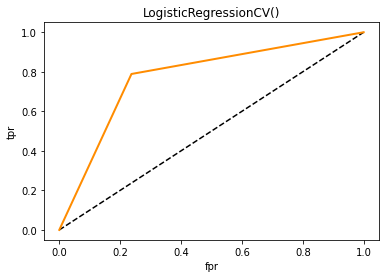

                          Model  recall_fire  precision_fire  recall_neutral  \
0  LogisticRegressionCV_minimax     0.788889        0.755319        0.762887   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.795699      2.0         2.0        0.775888  0.775888  
(1, 9)
(14, 9)


In [93]:
#Predict the model with all models with pre-processed data
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['KNN_minimax','KNeighborsClassifier','n_neighbors=5'],['XGBoost_minimax','XGBClassifier','max_depth=2'],['RandomForest_minimax','RandomForestClassifier','n_estimators=100'],['SVM_minimax','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree_minimax','DecisionTreeClassifier',''],['Naive_Bayes_minimax','GaussianNB',''],['LogisticRegressionCV_minimax','LogisticRegressionCV','']]

#eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,X_train_minmax, y_train_T, X_test_minmax,y_test_T)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models.shape)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval.csv',header=True, index=False)


## PCA - This is a technique that comes from the field of linear algebra and can be used as a data preparation technique to create a projection of a dataset prior to fitting a model.- Unsupervised
https://machinelearningmastery.com/calculate-principal-component-analysis-scratch-python/

In [94]:
from sklearn.decomposition import PCA as RandomizedPCA
from xgboost.sklearn import XGBRegressor

In [95]:
pca=RandomizedPCA(n_components=300, whiten=True).fit(X_train_minmax)
x_train_pca=pca.transform(X_train_minmax)


797.4129207253134 0.8763872751124312


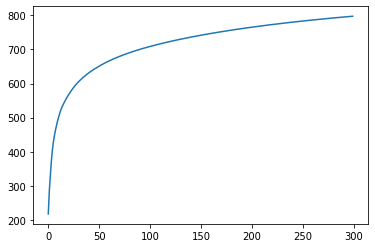

In [96]:
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.cumsum(explained_variance))
print(np.sum(explained_variance), np.sum(explained_variance_ratio))

In [97]:
pca=RandomizedPCA(n_components=45, whiten=True).fit(X_train_minmax)
x_train_pca=pca.transform(X_train_minmax)
x_test_pca=pca.transform(X_test_minmax)



In [98]:
print(x_train_pca.shape)
print(x_test_pca.shape)

(1775, 45)
(187, 45)


## Repeat SKLEARN Machine Learning  WITH PCAed data as above 

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = KNeighborsClassifier(n_neighbors=5)


*************************************************************************************
FOR KNN_minimax_pca:
ACCURACY: 0.7165775401069518
F1 SCORE: 0.7579908675799087
CONFUSION MATRIX: 
[[51 46]
 [ 7 83]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         0.0       0.88      0.53      0.66        97
         1.0       0.64      0.92      0.76        90

    accuracy                           0.72       187
   macro avg       0.76      0.72      0.71    

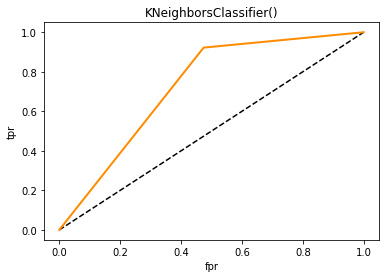

             Model  recall_fire  precision_fire  recall_neutral  \
0  KNN_minimax_pca     0.922222        0.643411        0.525773   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0            0.87931      2.0         2.0        0.723998  0.723998  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = XGBClassifier(max_depth=2)


*************************************************************************************
FOR XGBoost_minimax_pca:
ACCURACY: 0.7540106951871658
F1 SCORE: 0.7472527472527473
CONFUSION MATRIX: 
[[73 24]
 [22 68]]
CLASSIFICATI

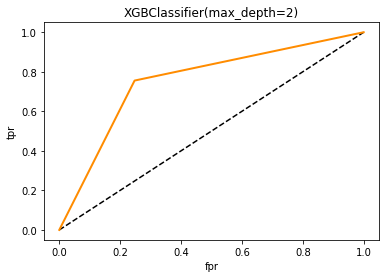

                 Model  recall_fire  precision_fire  recall_neutral  \
0  XGBoost_minimax_pca     0.755556         0.73913        0.752577   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.768421      2.0         2.0        0.754066  0.754066  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = RandomForestClassifier(n_estimators=100)


*************************************************************************************
FOR RandomForest_minimax_pca:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7613636363636365
CONFUSION MATRIX: 
[[78

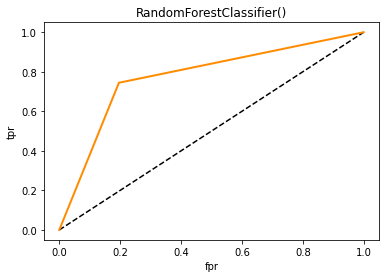

                      Model  recall_fire  precision_fire  recall_neutral  \
0  RandomForest_minimax_pca     0.744444         0.77907        0.804124   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.772277      2.0         2.0        0.774284  0.774284  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LinearSVC(random_state=0, tol=1e-5)


*************************************************************************************
FOR SVM_minimax_pca:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7765957446808511
CONFUSION MATRIX: 
[[72 25]

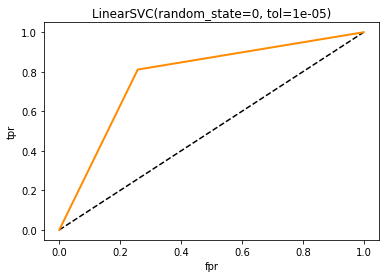

             Model  recall_fire  precision_fire  recall_neutral  \
0  SVM_minimax_pca     0.811111        0.744898        0.742268   

   precision_neutral  f1_fire  f1_neutral  model_accuracy  roc_auc  
0           0.808989      2.0         2.0         0.77669  0.77669  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = DecisionTreeClassifier()


*************************************************************************************
FOR DecisionTree_minimax_pca:
ACCURACY: 0.7272727272727273
F1 SCORE: 0.698224852071006
CONFUSION MATRIX: 
[[77 20]
 [31 59]]
CLASSIFICATI

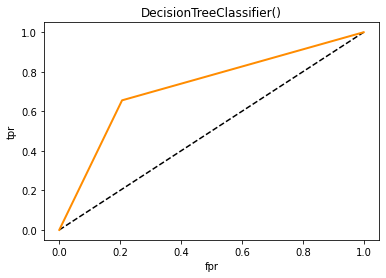

                      Model  recall_fire  precision_fire  recall_neutral  \
0  DecisionTree_minimax_pca     0.655556        0.746835        0.793814   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.712963      2.0         2.0        0.724685  0.724685  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GaussianNB()


*************************************************************************************
FOR Naive_Bayes_minimax_pca:
ACCURACY: 0.7379679144385026
F1 SCORE: 0.7262569832402235
CONFUSION MATRIX: 
[[73 24]
 [25 65]]
CLAS

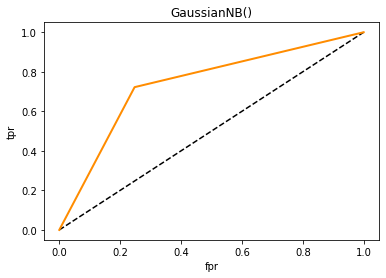

                     Model  recall_fire  precision_fire  recall_neutral  \
0  Naive_Bayes_minimax_pca     0.722222        0.730337        0.752577   

   precision_neutral  f1_fire  f1_neutral  model_accuracy  roc_auc  
0           0.744898      2.0         2.0          0.7374   0.7374  
(1, 9)
                          Model  recall_fire  precision_fire  recall_neutral  \
0          LogisticRegressionCV     0.622222        0.717949        0.773196   
0                   Naive_Bayes     0.666667        0.674157        0.701031   
0                  DecisionTree     0.622222        0.700000        0.752577   
0                           SVM     0.611111        0.723684        0.783505   
0                  RandomForest     0.677778        0.726190        0.762887   
0                       XGBoost     0.722222        0.755814        0.783505   
0                           KNN     0.611111        0.647059        0.690722   
0  LogisticRegressionCV_minimax     0.788889        0.755319    

In [99]:
#Predict the model with all models with pre-processed data
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
arr_models = [['KNN_minimax_pca','KNeighborsClassifier','n_neighbors=5'],['XGBoost_minimax_pca','XGBClassifier','max_depth=2'],['RandomForest_minimax_pca','RandomForestClassifier','n_estimators=100'],['SVM_minimax_pca','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree_minimax_pca','DecisionTreeClassifier',''],['Naive_Bayes_minimax_pca','GaussianNB','']]

#eval_data_for_all_models = pd.DataFrame()
current_df = pd.DataFrame()


for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,x_train_pca, y_train_T, x_test_pca,y_test_T)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval.csv',header=True, index=False)

## Cross Validation (Grid Search) PCA data as data rows are less

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = LogisticRegressionCV()


*************************************************************************************
FOR LogisticRegressionCV_minimax_pca:
ACCURACY: 0.7754010695187166
F1 SCORE: 0.7765957446808511
CONFUSION MATRIX: 
[[72 25]
 [17 73]]
CLASSIFICATION REPORT: 
              precision    recall  f1-score   support

         0.0       0.81      0.74      0.77        97
         1.0       0.74      0.81      0.78        90

    accuracy                           0.78       187
   macro avg       0.78      0.78      0.78

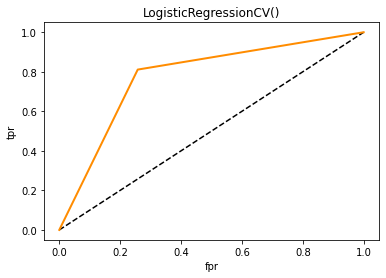

                              Model  recall_fire  precision_fire  \
0  LogisticRegressionCV_minimax_pca     0.811111        0.744898   

   recall_neutral  precision_neutral  f1_fire  f1_neutral  model_accuracy  \
0        0.742268           0.808989      2.0         2.0         0.77669   

   roc_auc  
0  0.77669  
(1, 9)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
svc = svm.SVC(kernel='rbf', class_weight='balanced')

model = GridSearchCV(estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]})


*********************************************************************************

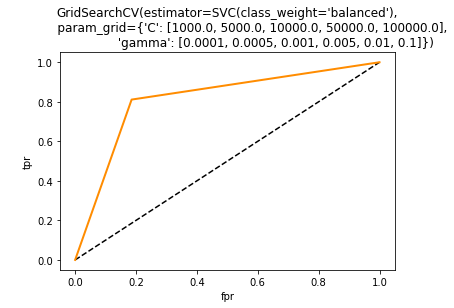

                      Model  recall_fire  precision_fire  recall_neutral  \
0  GridSearchCV_minimax_pca     0.811111        0.802198        0.814433   

   precision_neutral  f1_fire  f1_neutral  model_accuracy   roc_auc  
0           0.822917      2.0         2.0        0.812772  0.812772  
(1, 9)
                              Model  recall_fire  precision_fire  \
0              LogisticRegressionCV     0.622222        0.717949   
0                       Naive_Bayes     0.666667        0.674157   
0                      DecisionTree     0.622222        0.700000   
0                               SVM     0.611111        0.723684   
0                      RandomForest     0.677778        0.726190   
0                           XGBoost     0.722222        0.755814   
0                               KNN     0.611111        0.647059   
0      LogisticRegressionCV_minimax     0.788889        0.755319   
0               Naive_Bayes_minimax     0.688889        0.673913   
0              Decis

In [100]:
#Predict the model with Logistic & Grid search CV models with pre-processed data
arr_models = [['LogisticRegressionCV_minimax_pca','LogisticRegressionCV',''],["GridSearchCV_minimax_pca","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]
#arr_models = [['KNN','KNeighborsClassifier','n_neighbors=5'],['XGBoost','XGBClassifier','max_depth=2'],['RandomForest','RandomForestClassifier','n_estimators=100'],['SVM','LinearSVC','random_state=0, tol=1e-5'],['DecisionTree','DecisionTreeClassifier',''],['Naive_Bayes','GaussianNB',''],['LogisticRegressionCV','LogisticRegressionCV',''],["GridSearchCV","GridSearchCV","estimator=svc,param_grid={'C':[1e3, 5e3, 1e4, 5e4, 1e5],'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}"]]

current_df = pd.DataFrame()

for model_args in arr_models:
    model_eval_data=predict_classic_models(model_args,x_train_pca, y_train_T, x_test_pca,y_test_T)
    current_df=pd.concat([model_eval_data,current_df])

eval_data_for_all_models = pd.concat([eval_data_for_all_models , current_df])
print(eval_data_for_all_models)
eval_data_for_all_models.to_csv(RootFolder+'/step0_frameFile_comparison_model_eval.csv',header=True, index=False)

## Example ----
#### Saving the model as a pickel, retrieving the model and testing the model

In [101]:
#Testing the saved model
#now we weill load the saved model
#with open(ModelSaveFolder+'/FireDetection_SVM_Model_pickle', 'rb') as file:
#    loaded_model = pickle.load(file)
#    y1_predict_test = loaded_model.predict(x_test)
#    print(y1_predict_test)